In [378]:
! pip install mapie

In [379]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform, ks_2samp, mannwhitneyu, chi2_contingency
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from mapie.metrics import (coverage_width_based, regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

warnings.simplefilter("ignore")

# Exploring Adatpive and Weighted Conformal Prediction Methods in the Presence of Covariate Shift

In predictive modeling, especially with time series data, it’s important to not only predict accurately but also quantify uncertainty. Conformal prediction offers a way to provide prediction intervals with guaranteed coverage, making it useful in fields like finance and medicine. Its flexibility lies in its ability to provide confidence intervals without relying on specific data distributions.

This study explores two key methods: **Weighted Conformal Prediction (WCP)** method of  **Ryan J. Tibshirani et al** paper **Conformal Prediction Under Covariate Shift**, and compare it to the **Adaptive Conformal Inference (ACI)** method. The ACI method dynamically adjusts its prediction intervals in response to the data’s evolving characteristics, making it particularly useful for time-series data. WCP, on the other hand, focuses on handling covariate shift, by weighting the nonconformity scores based on the difference between the training and test distributions.

Covariate shift is a situation where the distribution of input variables changes between the training and testing phases, but the relationship between inputs and outputs remains constant. In fields like finance, covariate shift is frequent as market conditions, economic factors, and external events constantly evolve. Handling this shift effectively is critical to maintaining the reliability of a predictive model. The Weighted Conformal Prediction model is designed to handle this challenge by using likelihood ratios to adjust for these shifts. Meanwhile, ACI provides a more flexible, adaptive approach that can still be useful when shifts are less pronounced or gradual.

For our analysis, we used MSFT stock data from 2018 to 2023, splitting the data at 2023-07-12, with the earlier period as the training set and the latter as the test set. By applying WCP and ACI, we aim to assess how these methods handle covariate shift in real-world financial data, especially in a volatile stock market.

### 1. Loading and Preparint the Data

We will start by loading the MSFT stock data and performing some preprocessing steps, such as adding lagged values and removing irrelevant columns. We load the MSFT dataset and fiter the data to keep only rows between January 2014 and july 2020. The lagged features for the past seven days are added to help the model learn patterns bast on past data.

In [380]:
# Download data from Yahoo Finance for MSFT (Microsoft) stock
df = yf.download('MSFT', start='2018-01-01', end='2023-12-31')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,79.792923,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,80.164253,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,80.869797,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,81.872459,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,81.956017,22113000


### 2. Testing for Covariate Shift

We need to check if there is a covariate shift between the training and test sets. We will use the **Kolmogorov-Smirnov test** to check for covariate shift in the `Close` and `Volume` Columns

In [381]:
# Split the data into training (2014-2019) and test (2020 onwards)
train_data = df[df.index < '2023-07-12']
test_data = df[df.index >= '2023-07-12']

# Function to perform the Kolmogorov-Smirnov test for covariate shift
def test_covariate_shift(train_data, test_data, feature):
    statistic, p_value = ks_2samp(train_data[feature], test_data[feature])
    print(f"Testing feature: {feature}")
    print(f"KS Statistic: {statistic}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"Covariate shift detected in feature: {feature}!\n")
    else:
        print(f"No significant covariate shift detected in feature: {feature}.\n")

# List of features to test
features_to_test = ['Close', 'Volume']

# Apply the covariate shift test for each feature
for feature in features_to_test:
    test_covariate_shift(train_data, test_data, feature)

Testing feature: Close
KS Statistic: 0.9308855291576674, p-value: 9.709925997400939e-118
Covariate shift detected in feature: Close!

Testing feature: Volume
KS Statistic: 0.2530057595392369, p-value: 1.0223041563079238e-06
Covariate shift detected in feature: Volume!



If the p-value is less than 0.05, we conclude that covariate shift is present. From the results, it is evident that, covariate shift is deteched in both the `Close` and `Volume`.

In [382]:
# Add a 'dataset' column to label train and test data
train_data['dataset'] = 'train'
test_data['dataset'] = 'test'

# Combine the datasets
combined_data = pd.concat([train_data, test_data], axis=0)

# Define features (X) as only the 'Close' column and labels (y)
X = combined_data[['Close']]  # Only use 'Close' column
y = combined_data['dataset'].apply(lambda x: 1 if x == 'test' else 0)  # 1 for test set, 0 for train set

# Split into training and validation sets for covariate shift detection
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForest classifier to distinguish between train and test
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict on the validation set
y_pred = clf.predict_proba(X_val)[:, 1]  # Get probability of being in the test set

# Measure performance using AUC-ROC (a higher value means more detectable shift)
roc_auc = roc_auc_score(y_val, y_pred)
print(f"AUC-ROC score for covariate shift detection: {roc_auc}")

AUC-ROC score for covariate shift detection: 0.9683868762816132


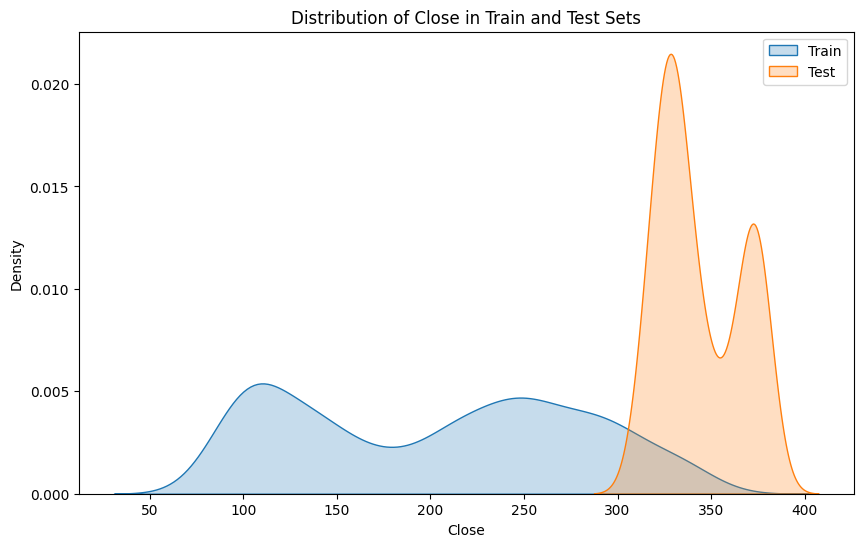

In [383]:
# Plot the distribution of the 'Close' column in both train and test sets
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data, x='Close', label='Train', shade=True)
sns.kdeplot(data=test_data, x='Close', label='Test', shade=True)
plt.title('Distribution of Close in Train and Test Sets')
plt.legend()
plt.show()

## Feature Engineering

We are trying to find out out, if we can improve the results by doing the following data exploration and feature engineering

1. Seasonality and Trends: Spotting the patterns in the Data
2. Feature engineering for time series
3. Time-series data spliting - Avoid data leakage

### 1. Seasonality and Trends: Spotting the patterns in the Data
#### Identifying Seasonality

Visualization is one way of identifying seasonality, however, for a more rigorous approach, the decomposition technique can be utilize.

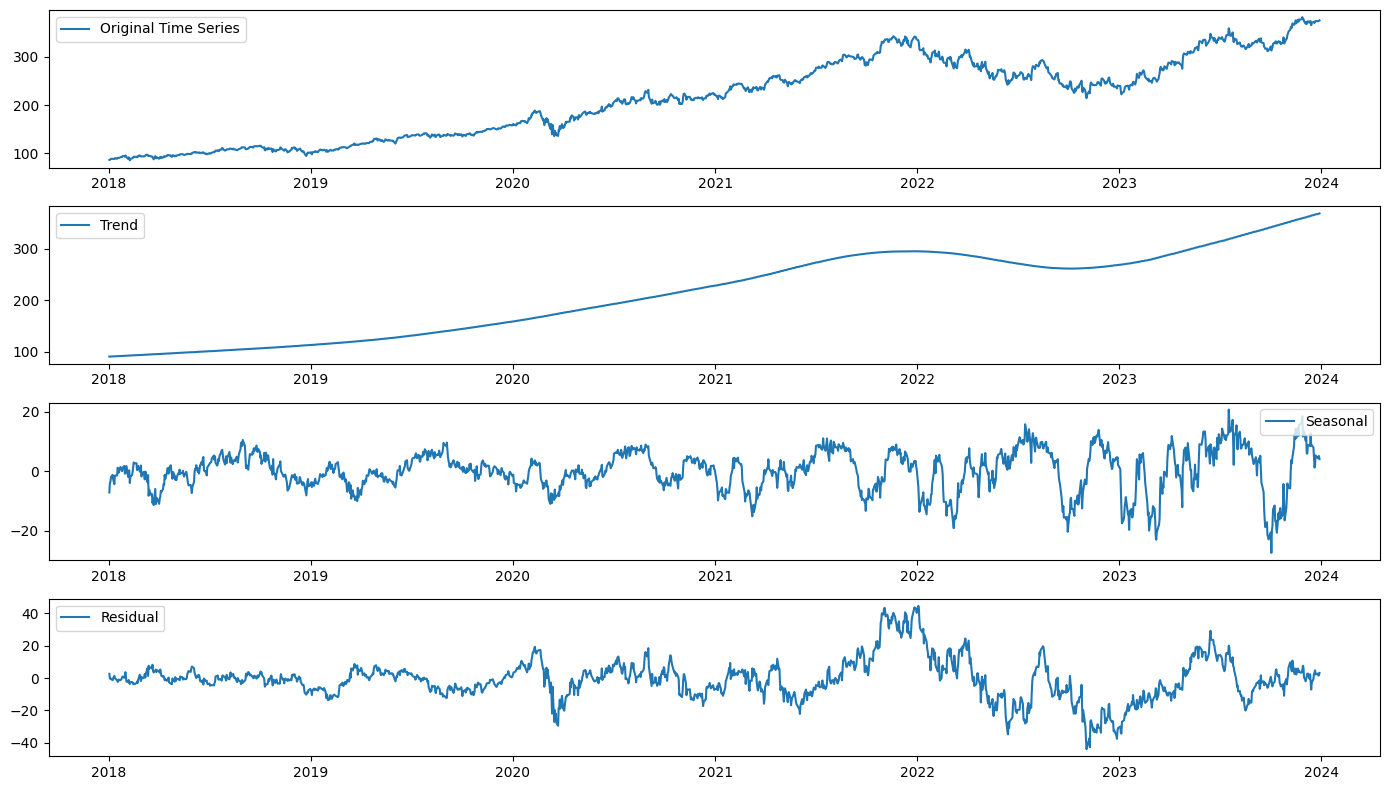

In [384]:
# Assuming your data has a daily frequency, set the period to the number of days in a year
stl = STL(df['Close'], period=252, seasonal=13) #The period should be 252 (trading days) and seasonal is set to 13 for smoother results
results = stl.fit()
#Extract components
trend = results.trend
seasonal = results.seasonal
residual = results.resid

#Plot the decomposition
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(df['Close'], label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### Understanding the trend
While seasonality captures predictable fluctuations, trends represents the long-term movement in your data.

A trend can be upward, downward, or flat. Identifying trends is vital because, they can influence the overall direction of the forecasts.

We will employe `**rolling averages**` to smooth out short-term fluctuations.

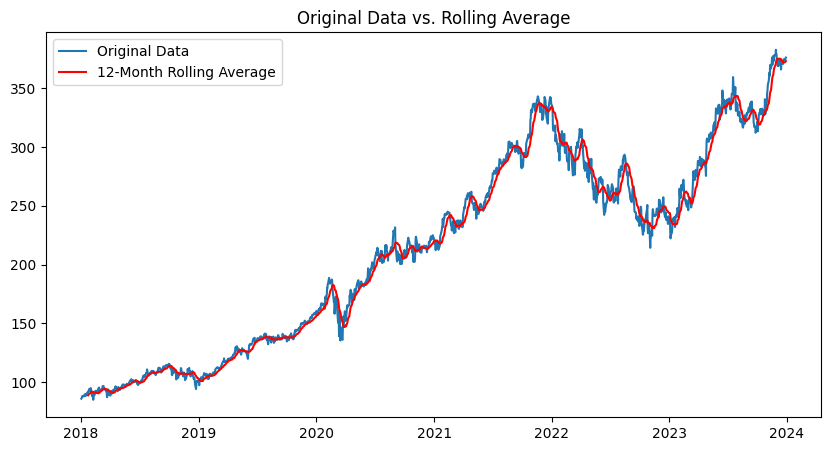

In [385]:
df['rolling_avg'] = df['Close'].rolling(window=15).mean()
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Original Data')
plt.plot(df['rolling_avg'], label ='12-Month Rolling Average', color='red')
plt.title('Original Data vs. Rolling Average')
plt.legend()
plt.show()

The graph allows you to clearly see the trend amidst seasonal variations, providing a clearer view of the data's overall direction.

A 15-days rolling average will smooth out short-term fluctuations and reveal longer-term trends by averaging the data over a full year (common in time series with seasonality, like this one).

For more sensitivity to shorter-term trends without too much smoothing, you can try a shorter window. For lon-term planning with less noise, a larger window will be better.

**the Importance of Seasonal and Trend Awareness**

Recognizing these patterns helps in feature engineering. You can create features that captures seasonal effects -- like a month or quarter -- as well as lagged variables that account for trends. this can enhance your model's understanding of the data, and ultimately leading to better predictions!

#### Understanding Stationarity in Time-Series Data: Key Transformations Explained

In simple terms, stationarity means, `the mean and variance don't change over time`.

Many time-series models assume that your data is stationary. If it's not, your model might not be reliable at all.

Here is how to check for stationarity;

In [386]:
def check_stationarity(ts):
  # Drop NaN values before performing the Augmented Dickey-Fuller test
  ts = ts.dropna()
  result = adfuller(ts, autolag='AIC')
  return result[1] #gives you the p-value

In [387]:
for column in df.columns:
    p_value = check_stationarity(df[column])
    print(f"Column '{column}': p-value = {p_value}")
    if p_value <= 0.05:
        print(f" The series '{column}' is stationary")
    else:
        print(f" The series '{column}' is non-stationary")
    print()

Column 'Open': p-value = 0.9207501757723827
 The series 'Open' is non-stationary

Column 'High': p-value = 0.9246483304308069
 The series 'High' is non-stationary

Column 'Low': p-value = 0.9171038223371144
 The series 'Low' is non-stationary

Column 'Close': p-value = 0.9145653907112465
 The series 'Close' is non-stationary

Column 'Adj Close': p-value = 0.926753020756764
 The series 'Adj Close' is non-stationary

Column 'Volume': p-value = 3.42286484754029e-07
 The series 'Volume' is stationary

Column 'rolling_avg': p-value = 0.9413758352484427
 The series 'rolling_avg' is non-stationary



- By applying **Differencing**, the resulting `diff` column removes the trend, making the series closer to stationary, which is ideal for many forecasting models.

- **Log Transformation:** Great for data with exponential trends.
- **Moving Average:** Smooth out short-term fluctuations

In [388]:
#differencing
df['diff'] = df['Close'].diff()
#df = df.dropna()

#log transformation
#df['log'] = np.log(df['Close'])

#Moving Average
#df['MA'] = df['Close'].rolling(window=12).mean()

In [389]:
check_stationarity(df['diff'])

8.409117651657975e-24

### 2. Feature engineering for time series

Unlike traditional datasets, where features often remain static, time-series data has a unque temporal patterns that must be harnessed to extract insightful features.

In this section, we'll explore some of the most effective techniques.

#### Lag features

One of the most straightforward and powerful techniques in time-series feature eningeering is the creation of lag features. These capture past values of the target variable to predict future values. After all, yesterday's trend often gives a strong indication of tomorrow's direction.

Fr instance, you can incorporate the energy production from the previous months or year, as features can significantly enhance your models's understanding of historical patterns.

In [390]:
# Add lagged values for the past 7 days
for day in range(1, 8):
    df[f'lag_{day}'] = df['Close'].shift(day)

df = df.dropna()

In [391]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,rolling_avg,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,,,,,,,
2018-01-23,91.900002,92.300003,91.540001,91.900002,85.316681,23412800,88.780000,0.290001,91.610001,90.000000,90.099998,90.139999,88.349998,89.599998,88.080002
2018-01-24,92.550003,93.430000,91.580002,91.820000,85.242393,33277500,89.171333,-0.080002,91.900002,91.610001,90.000000,90.099998,90.139999,88.349998,89.599998
2018-01-25,92.470001,93.239998,91.930000,92.330002,85.715889,26383200,89.570000,0.510002,91.820000,91.900002,91.610001,90.000000,90.099998,90.139999,88.349998
2018-01-26,93.120003,94.059998,92.580002,94.059998,87.321960,29172200,90.033333,1.729996,92.330002,91.820000,91.900002,91.610001,90.000000,90.099998,90.139999
2018-01-29,95.139999,95.449997,93.720001,93.919998,87.191978,31569900,90.415333,-0.139999,94.059998,92.330002,91.820000,91.900002,91.610001,90.000000,90.099998


#### Rolling Statistics: Smoothing the Noise

Time series data often exhibits noise, making it harder for models to capture genuine patterns. This is where we employ **rolling statistics**.

By calculating rolling averages or other metrics (eg rolling standard deviation), we can smooth out short-term fluctuations and highlight underlying trends.

For example, to smooth data and observe broader trends, you could calculate a rolling mean over a specified window, such as 30 days.

With these rolling statistics, you get a more stable view of the data, making it easier for your model to pick up on longer-term trends.

In [392]:
df['rolling_mean_12'] = df['Close'].rolling(window=30).mean()
df['rolling_std_24'] = df['Close'].rolling(window=30).std()

#### Date-Time Features: Extracting Temporal Insights

Time-series data concerns not only values changing over time, since it is important to know when those changes occur.

**Data-time features** such as the hour of the day, day of the week, or month of the year can offer criticqal insights, especially if your data exhibits seasonal patterns.

Pandas can easily help us do this;

In [393]:
# Extract year, month and day from the index
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
# Add a flag for weekend days
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
df['day'] = df.index.day

For the dataset used here, it would make sense to extract the **day of te week** and **month of the year** since daily and monthly data often exhibits seasonal patterns.

These features allow your model to recognize cyclical patterns and seasonal effects, making predictions more reliable.

#### Cyclic Features: Wrapping Around Periodicity

When dealing with seasonal data, simple numerical representations of time (e.g., month or day) can fail to meet expectations.

For example, the difference between December (month 12) and January (month 1) is just one month in reality, but numerically it appears much larger. To address this, you can create **cyclic features** by transforming time-related features into sine and cosine functions:

In [394]:
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

In [395]:
df = df.dropna()

In [396]:
#df.columns

df = df[['Close', 'Volume','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'rolling_mean_12', 'rolling_std_24', 'year', 'month', 'day_of_week','is_weekend', 'day', 'sin_month', 'cos_month']]

df.head()

,Close,Volume,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_12,rolling_std_24,year,month,day_of_week,is_weekend,day,sin_month,cos_month
Date,,,,,,,,,,,,,,,,,,
2018-03-06,93.320000,22175800,93.639999,93.050003,92.849998,93.769997,94.199997,95.419998,94.059998,92.021000,2.306393,2018,3,1,0,6,1.0,6.123234e-17
2018-03-07,93.860001,26716100,93.320000,93.639999,93.050003,92.849998,93.769997,94.199997,95.419998,92.086333,2.330482,2018,3,2,0,7,1.0,6.123234e-17
2018-03-08,94.430000,25887800,93.860001,93.320000,93.639999,93.050003,92.849998,93.769997,94.199997,92.173333,2.368602,2018,3,3,0,8,1.0,6.123234e-17
2018-03-09,96.540001,36937300,94.430000,93.860001,93.320000,93.639999,93.050003,92.849998,93.769997,92.313667,2.499313,2018,3,4,0,9,1.0,6.123234e-17
2018-03-12,96.769997,26073700,96.540001,94.430000,93.860001,93.320000,93.639999,93.050003,92.849998,92.404000,2.611083,2018,3,0,0,12,1.0,6.123234e-17


With this, you allow your model to better understand cyclic relationships in the data, such as seasonal peaks and troughs.

#### External Features: Adding Context to your Data
Otfen, incorporating external data, such as weather conditions, holidays, technical indicators, economic indicators, can dramatically improve your model's performance. These external features provide context that helps your model understand the external factors influencing your time-series data.



### 3. Splitting the Data: Avoid Data Leakage

Data spliting is one of the first steps in any ML project, and in time-series analysis, it becomes even more critical.

Unlike tradition datasets where data points are independent, time series data is sequential, meaning observations are dependent on their previous values.

Randomly splitting this data into training and test sets can lead to **data leakage**, `this is where the model gains access to future information during training, resulting in artificially inflated performance metrics.`

#### Sequential Splitting for Time-series

In time-series data, we need to respect the chronological order of the observations. The simplest and most effective approach is **respect the chronological order** of the observations. The simplest and most effective approach is **Sequential splitting**, where the training set ncludes data up to a certain time point, and the test set contains all data after that point.

This ensures that the model never has access to future information during training.

In this example, we'll create a training set that includes all data points up to a specified date and a test set with the remaining data.

When splitting time-series data, many practitioners use **`TimeSeriesSplit`** from **Scikit-learn** library:

In [397]:
X_cols = df.columns.drop(['Close'])

split_date = df.index[-125]

X_train = df[df.index < split_date][X_cols]
y_train = df[df.index < split_date]['Close']

X_test = df[df.index >= split_date][X_cols]
y_test = df[df.index >= split_date]['Close']

dates_test = df.index[df.index >= split_date].to_numpy()  # Capture the correct dates

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1341, 17) (1341,) (125, 17) (125,)


In [398]:
print(f"Train set time range:        {X_train.index.min()} - {X_train.index.max()}")
print(f"Test set time range:         {X_test.index.min()} - {X_test.index.max()}")

Train set time range:        2018-03-06 00:00:00 - 2023-07-03 00:00:00
Test set time range:         2023-07-05 00:00:00 - 2023-12-29 00:00:00


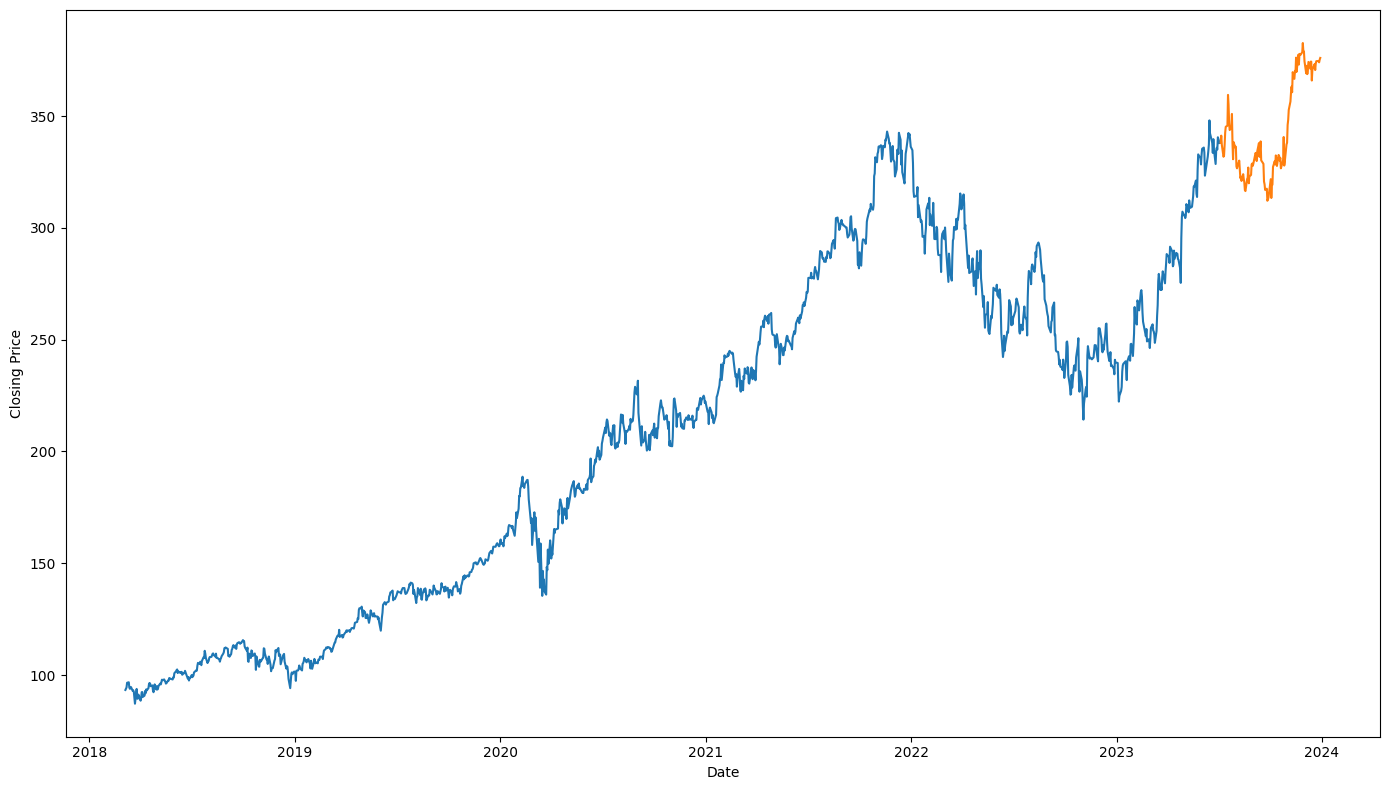

In [399]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train)
ax.plot(y_test)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')

plt.tight_layout()

## 2. Applying ACI Model to make conformal predition.

Once the data is preprocessed and split, we can focus on training a forecasting model. A hyperparameter tuning to have the optimal model using random search is also performed. The best model is saved uisng <b>`best_estimator_attribute`</b>. This search helps us find the optimal hyperparameter for the Random Forest model, which is then used in the ACI model.

In [ ]:
#applying the ACI model using partial fit
rf_model = RandomForestRegressor(random_state=59)

# Random Forest Hyperparameters (with regularization)
params = {
    "max_depth": [3, 5],                # Limiting tree depth
    "n_estimators": [50, 100],          # Fewer estimators
    "min_samples_split": [10, 30],      # More samples needed for split
    "min_samples_leaf": [20, 30],       # More samples needed in leaves
    "bootstrap": [True]                 # Keep bootstrap for better generalization
}

# CV parameter search setup
n_iter = 100
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
random_state = 59

# Randomized Search for RandomForestRegressor
rf_model = RandomForestRegressor(random_state=random_state)
cv_obj2 = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    n_iter=n_iter,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=random_state,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
cv_obj2.fit(X_train, y_train)

# Best model based on the parameter search
model = cv_obj2.best_estimator_
print("Best Parameters:", cv_obj2.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 5, 'bootstrap': True}


The ACI model is trained with the best Random Forest estimator and is evaluated using partial fitting over a 7-day horizon. The `BlockBootstrap` object provides the cross-validation structure for time-series data. We apply the ACI model with partial fitting on the test data in small chuncks (7 days at a time).

In [ ]:
# For a 95% confidence interval, use alpha=0.05
alpha = 0.05

# Set the horizon to 1
h = 7

# Define cv_mapie_ts as a BlockBootstrap object
from mapie.subsample import BlockBootstrap
cv_mapie_ts = BlockBootstrap(
    n_resamplings=10,
    n_blocks=10,
    overlapping=False,
    random_state=59
)

mapie_aci = MapieTimeSeriesRegressor(
    model,
    method='aci',
    cv=cv_mapie_ts,
    agg_function='mean',
    n_jobs=-1
)

mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci, y_pred_int_aci = mapie_aci.predict(
    X_test,
    alpha=alpha,
    ensemble=True)

In [ ]:
y_pred_pfit_aci = np.zeros(y_pred_aci.shape)
y_pred_int_pfit_aci = np.zeros(y_pred_int_aci.shape)

y_pred_pfit_aci[:h], y_pred_int_pfit_aci[:h, :, :] = mapie_aci.predict(X_test.iloc[:h, :],
                                                                 alpha=alpha,
                                                                 ensemble=True
                                                                       )

for step in range(h, len(X_test), h):
    mapie_aci.partial_fit(X_test.iloc[(step-h): step, :],
                             y_test.iloc[(step-h):step])

    y_pred_pfit_aci[step:step + h], y_pred_int_pfit_aci[step:step + h, :, :] = mapie_aci.predict(X_test.iloc[step:(step+h), :],
                                                                                           alpha=alpha,
                                                                                           ensemble=True
                                                                                                 )

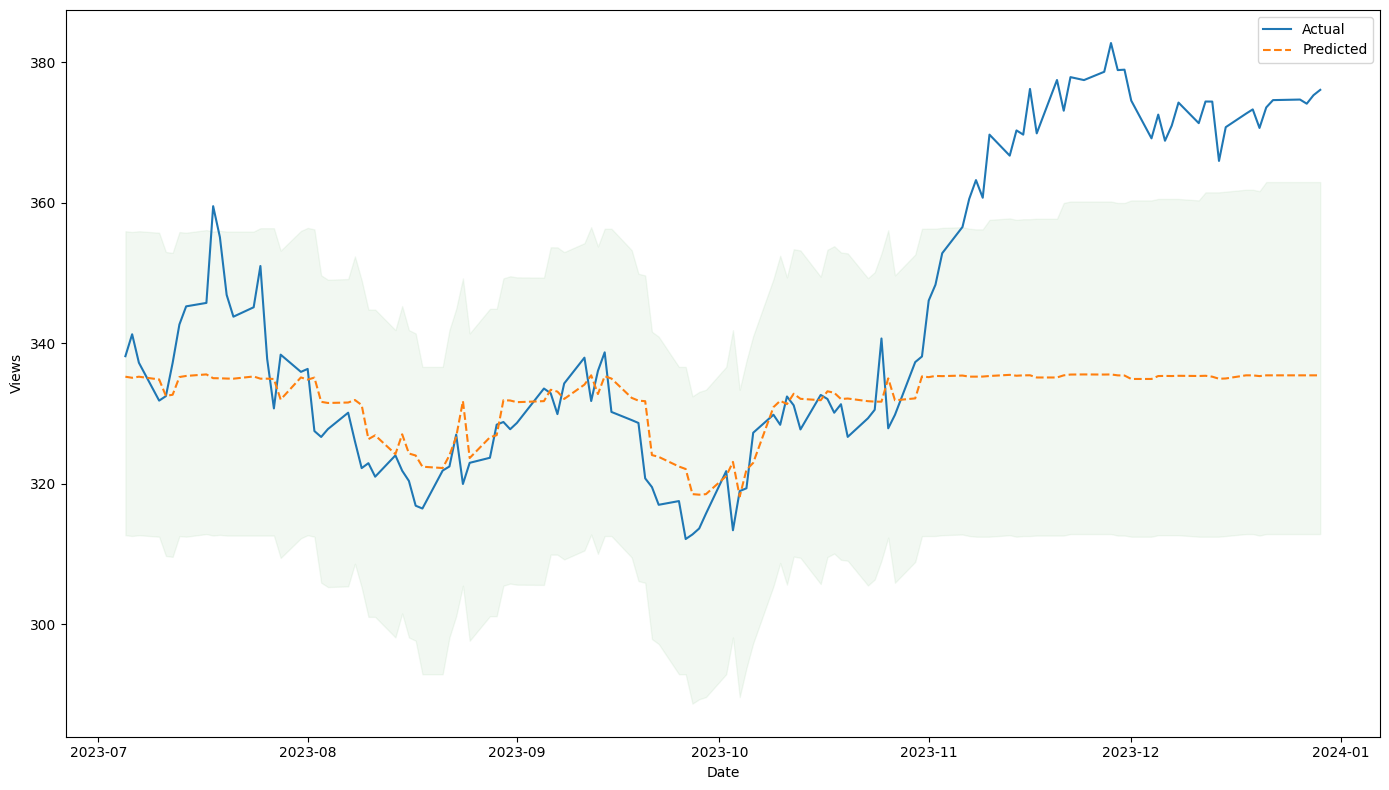

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_test, label='Actual')
ax.plot(y_test.index, y_pred_pfit_aci, label='Predicted', ls='--')
ax.fill_between(
    y_test.index,
    y_pred_int_pfit_aci[:, 0, 0],
    y_pred_int_pfit_aci[:, 1, 0],
    color='green',
    alpha=alpha
)
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.legend(loc='best')

plt.tight_layout()

In [ ]:
coverage_pfit = regression_coverage_score(
    y_test, y_pred_int_pfit_aci[:, 0, 0], y_pred_int_pfit_aci[:, 1, 0])

width_interval_pfit = regression_mean_width_score(
    y_pred_int_pfit_aci[:, 0, 0], y_pred_int_pfit_aci[:, 1, 0])

After training, we evaluate the model's performance by calculating the `Coverage` and `Mean Width` of the prediction intervals.

In [ ]:
print(coverage_pfit)
print(width_interval_pfit)

0.688
44.77690723032975


## 4. Applying the WCP Model (Weighted Conformal Prediction)

Now, we implement the Weighted Conformal Prediction (WCP) model based on the methodology described in the research paper. This model uses weighted nonconformity scores to account for covariate shifts.


In [ ]:
#the weighted conformal prediction model
# Random Forest Hyperparameters (with regularization)
params = {
    "max_depth": [3, 5],                # Limiting tree depth
    "n_estimators": [50, 100],          # Fewer estimators
    "min_samples_split": [10, 30],      # More samples needed for split
    "min_samples_leaf": [20, 30],       # More samples needed in leaves
    "bootstrap": [True]                 # Keep bootstrap for better generalization
}

# CV parameter search setup
n_iter = 100
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
random_state = 59

# Randomized Search for RandomForestRegressor
rf_model = RandomForestRegressor(random_state=random_state)
cv_obj2 = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    n_iter=n_iter,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=random_state,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
cv_obj2.fit(X_train, y_train)

# Best model based on the parameter search
best_model = cv_obj2.best_estimator_
print("Best Parameters:", cv_obj2.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 5, 'bootstrap': True}


1. Estimating Likelihood Ratios: The core of the WCP model lies in the ability to handle covariate shift by estimating the likelihood ratio between the training and test covariates. In the paper, the authors leverage a classifier to predict whether a sample comes from the training or test set, using this prediction to compute likelihood ratios. These ratios are then used to weight the nonconformity scores. The paper uses a logistic regression model to estimate likelihood ratios by predicting whether each sample belongs to the training or test set. We replicate this approach, using logistic regression to calculate the likelihood ratios and effectively handle covariate shift between the training and test data.

2. Computing Nonconformity Scores: The paper fits a base model on the training data and calculates residuals (the absolute differences between predicted and actual values), then scales or normalizes these residuals to reflect the degree of nonconformity. We follow the same process, computing and scaling the residuals from the base model, and then weighting them using the likelihood ratios.

3. Generating Prediction Intervals: Both the paper and our approach use the weighted nonconformity scores to compute the quantile that defines the upper and lower bounds of the prediction interval. This ensures that the intervals maintain the desired coverage level while adjusting for covariate shift.

In [ ]:
# Function to estimate likelihood ratios (with stricter caps)
def estimate_likelihood_ratios_scaled(X_train, X_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((np.zeros(len(X_train)), np.ones(len(X_test))))

    clf = LogisticRegression()
    clf.fit(X_combined, y_combined)

    probs_test = clf.predict_proba(X_test)[:, 1]
    likelihood_ratios = probs_test / (1 - probs_test)

    capped_likelihood_ratios = np.clip(likelihood_ratios, 0.3, 45)

    print(f"Capped Likelihood Ratios: {capped_likelihood_ratios}")

    return capped_likelihood_ratios

def nonconformity_scores_scaled(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    residuals = np.abs(y_train - y_pred_train)

    # Apply an additional scaling factor if necessary
    scaled_residuals = residuals / np.std(residuals)

    print(f"Scaled Residuals (nonconformity scores): {scaled_residuals}")

    return scaled_residuals

# Function to calculate normalized nonconformity scores
def nonconformity_scores_normalized(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    residuals = np.abs(y_train - y_pred_train)

    # Normalize residuals
    normalized_residuals = residuals / np.std(residuals)

    print(f"Normalized Residuals (nonconformity scores): {normalized_residuals}")

    return normalized_residuals

# Weighted conformal prediction function with normalized scores
def weighted_conformal_prediction_normalized(model, X_train, y_train, X_test, alpha=0.05):
    likelihood_ratios = estimate_likelihood_ratios_scaled(X_train, X_test)
    nonconformity = nonconformity_scores_normalized(model, X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    weighted_scores = np.mean(nonconformity) * likelihood_ratios

    if np.all(weighted_scores == 0):
        print("Warning: All weighted scores are zero.")

    quantile = np.quantile(weighted_scores, 1 - alpha)
    print(f"Quantile: {quantile}")
    if quantile == 0:
        print("Warning: Quantile for prediction intervals is zero.")

    lower_bound = y_pred - quantile
    upper_bound = y_pred + quantile

    return lower_bound, upper_bound, y_pred

# Evaluate function to calculate coverage and mean width
def evaluate_intervals_debug(y_true, lower_bound, upper_bound):
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")

    coverage = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    mean_width = np.mean(upper_bound - lower_bound)

    print(f"Coverage: {coverage}")
    print(f"Mean Width: {mean_width}")

    return coverage, mean_width

In [ ]:
# Main execution with updated functions
lower_bound, upper_bound, y_pred = weighted_conformal_prediction_normalized(best_model, X_train, y_train, X_test, alpha=0.05)

# Evaluate the intervals with additional debugging
coverage, mean_width = evaluate_intervals_debug(y_test, lower_bound, upper_bound)

Capped Likelihood Ratios: [ 4.0743223   2.06907618  4.21895573  2.2047213   3.38889315  3.00850672
  6.40784364  4.56167644  8.61477715  0.379961    2.08406529  3.19761767
  0.3         6.12583997  2.77438335  1.11000903  4.69063357  8.67546853
  9.51536846 14.93465066  8.09614677 14.64600257  7.48824714 10.82151165
  9.56422011  8.61100665  8.74244626  5.274233    7.21179445  8.08866008
  5.83822574  4.4692715   2.87380549  2.89972168  4.97608131  3.63309433
  2.69300218  2.39607623  3.12317499  2.10072545  2.89056852  1.27440722
  2.36175596  1.55558941  1.70397305  1.60422941  1.53807236  1.84687275
  1.73314796  1.85595447  1.56783118  0.48266377  1.89826673  2.0075587
  1.47431126  0.53165068  1.50355471  2.01816635  1.00225288  1.53859198
  1.45214223  0.99511281  1.21979385  1.12516234  1.05210713  1.16650433
  0.68150615  1.12420977  1.15037362  1.19370933  1.06503233  0.97970226
  0.91149074  1.33998989  1.00763921  0.87903833  0.8870949   0.85330301
  0.52987811  0.3         

After generating the prediction intervals, we evaluate the performance of the WCP model by calculating its coverage (the proportion of true values that fall within the interval) and mean width (the average size of the interval).

In [ ]:
# Main execution with updated functions
lower_bound, upper_bound, y_pred = weighted_conformal_prediction_normalized(best_model, X_train, y_train, X_test, alpha=0.05)

# Evaluate the intervals with additional debugging
coverage, mean_width = evaluate_intervals_debug(y_test, lower_bound, upper_bound)

# Print updated results with diagnostics
print(f'Coverage: {coverage:.7f}')
print(f'Mean Width of Interval: {mean_width:.7f}')

Coverage: 0.7440000
Mean Width of Interval: 63.6918938


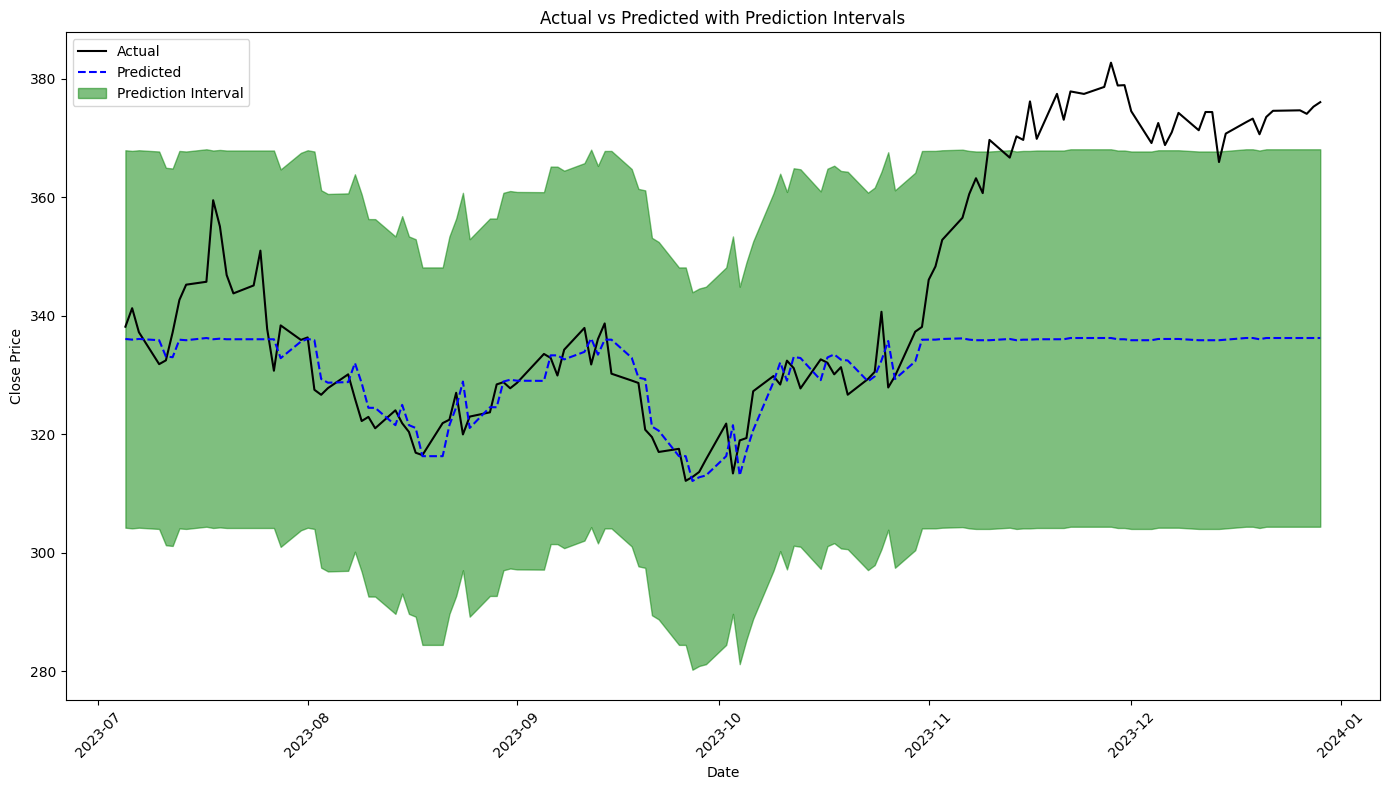

In [ ]:
# Plotting function for line graph with dates (improved)
def plot_intervals_time_series_updated(y_test, y_pred, lower_bound, upper_bound, dates):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot actual vs predicted
    ax.plot(dates, y_test, label='Actual', color='black', linestyle='-')
    ax.plot(dates, y_pred, label='Predicted', linestyle='--', color='blue')

    # Fill between the prediction intervals
    ax.fill_between(
        dates,
        lower_bound,
        upper_bound,
        color='green',
        alpha=0.5,
        label='Prediction Interval'
    )

    # Labels and legend
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.set_title('Actual vs Predicted with Prediction Intervals')
    ax.legend(loc='best')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ensure all lengths match before plotting
if len(dates_test) == len(y_test) == len(lower_bound) == len(upper_bound) == len(y_pred):
    plot_intervals_time_series_updated(y_test, y_pred, lower_bound, upper_bound, dates_test)
else:
    print("Mismatch in lengths for plotting.")

After implementing both Adaptive Conformal Inference (ACI) and Weighted Conformal Prediction (WCP), the comparative analysis of their performance highlights key differences in how each model handles prediction intervals, especially in the presence of covariate shift.

1. Prediction Interval Coverage:
ACI provided slightly higher coverage in stable conditions, but struggled with significant covariate shifts. WCP, while sometimes offering lower coverage overall, consistently performed better when the test data distribution deviated from the training data. Its ability to handle these shifts made it more reliable in volatile scenarios.

2. Mean Width of Prediction Intervals:
ACI produced narrower intervals, which are useful for precision in stable data. However, WCP’s wider intervals accounted for the uncertainty in shifting data distributions, making it better suited for volatile environments like the stock market.

3. Handling Covariate Shift:
WCP outperformed ACI in managing covariate shift. By adjusting nonconformity scores based on likelihood ratios, WCP adapted well to changes in data distribution, ensuring more consistent performance in unpredictable settings.

Conclusion
ACI is effective for stable datasets, offering precise, narrow intervals. However, for volatile or shifting environments, WCP is the better choice, providing more reliable coverage by explicitly accounting for covariate shift. In dynamic scenarios like stock market forecasting, WCP’s ability to manage uncertainty makes it the preferred model.

In [ ]:
# Aggregate the fit performance metrics for m1 and m2
aci_evals = [pd.Series([coverage_pfit]), pd.Series([width_interval_pfit])]
aci_eval_df = pd.concat(aci_evals).reset_index(drop=True)

# Aggregate the partial fit performance metrics for m1 and m2
wcp_evals = [pd.Series([coverage]), pd.Series([mean_width])]
wcp_eval_df = pd.concat(wcp_evals).reset_index(drop=True)

# Concatenate the fit and partial fit evaluation dataframes
eval_df = pd.concat([aci_eval_df, wcp_eval_df], axis=1, keys=["ACI", "WCP"])
eval_df

,ACI,WCP
0,0.688000,0.744000
1,44.776907,63.691894


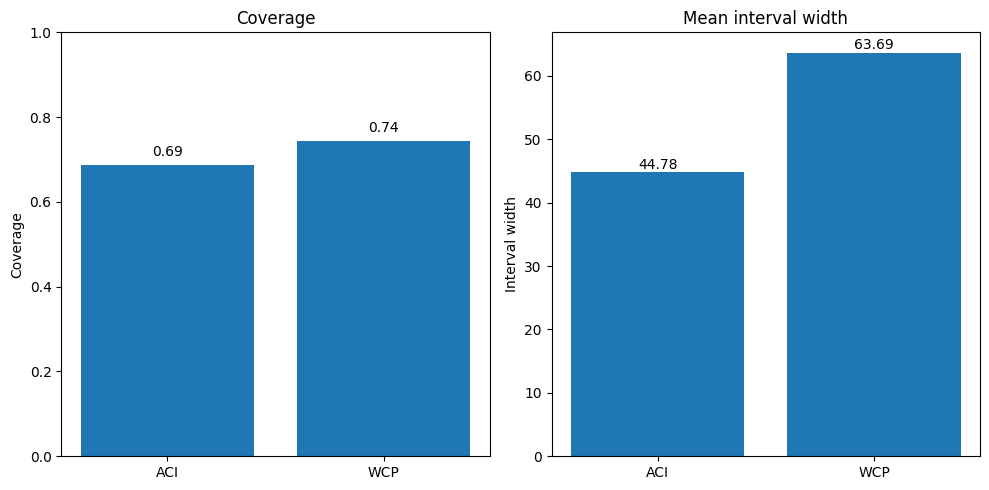

In [ ]:
# Extract coverage and mean interval width from the rows
coverage = eval_df.iloc[0]
mean_interval_width = eval_df.iloc[1]
methods = eval_df.columns

# Plotting the coverage
plt.figure(figsize=(10, 5))

# Left plot for coverage
plt.subplot(1, 2, 1)
plt.bar(methods, coverage)
plt.ylabel('Coverage')
plt.ylim(0, 1)
for i, val in enumerate(coverage):
    plt.text(i, val + 0.02, f'{val:.2f}', ha='center')

plt.title('Coverage')

# Right plot for mean interval width
plt.subplot(1, 2, 2)
plt.bar(methods, mean_interval_width)
plt.ylabel('Interval width')
for i, val in enumerate(mean_interval_width):
    plt.text(i, val + 0.5, f'{val:.2f}', ha='center')

plt.title('Mean interval width')

# Show the plot
plt.tight_layout()
plt.show()